In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.spatial.distance import pdist, cosine
from scipy import stats
from itertools import combinations, permutations
from scipy.stats import spearmanr
%matplotlib inline

df = pd.read_csv('../data/standard_eligible_observed.csv')
rcParams['font.sans-serif'] = 'arial'

age_classes = ((0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 100))

birth_classes = ((2008, 2018),
                 (1988, 2007),
                 (1974, 1987),
                 (1969, 1974),
                 (1957, 1968),
                 (1918, 1956))

def age_to_age_class(age, age_classes):
    for lb, ub in age_classes:
        if age >= lb and age <=ub:
            if lb != 65:
                ac = '-'.join((str(lb), str(ub)))
            else:
                ac = '65+'
            break
    return ac


def by_to_by_class(by, birth_classes):
    for lb, ub in birth_classes:
        if by >= lb and by <=ub:
            bc = '-'.join((str(lb), str(ub)))
            break
    return bc

def yr_to_label(yr):
    if yr != '2009Pan':
        label = str(int(yr) - 1) + '-' + yr
    else:
        label = yr
    return label

def label_to_season(label):
    if label != '2009Pan':
        l = str(int(label) - 1) + '-' + label
    else:
        l = label
    return l

h1_seasons = ['2009', '2009Pan', '2010', '2014', '2016']
h3_seasons = ['2008', '2011', '2012', '2013', '2015', '2017', '2018']
order=['2008', '2011', '2012', '2013', '2015', '2017', '2018', '2009', '2009Pan', '2010', '2014', '2016']
pal = sns.xkcd_palette(['dark sky blue', 'deep red']).as_hex()
h3_color=pal[1]
h1_color=pal[0]


obs_df = pd.DataFrame(index=sorted(list(set(df.birth_year))), columns=sorted(list(set(df.season))))
expect_df = pd.DataFrame(index=sorted(list(set(df.birth_year))), columns=sorted(list(set(df.season))))

for index, row in df.iterrows():
    if row.season in h1_seasons:
        cases = row.I_obs_h1 + row.I_vac_h1
    else:
        cases = row.I_obs_h3 + row.I_vac_h3
    
    obs_df.loc[row.birth_year, row.season] = cases


obs_df = obs_df.fillna(0)
cases = obs_df.copy()
dominant_subtype_cases = cases.sum()

SpearmanrResult(correlation=0.11883351367934894, pvalue=0.02224371470051062)
SpearmanrResult(correlation=0.05449601861641764, pvalue=0.19466809890196285)


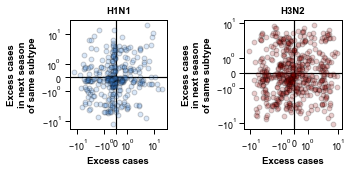

In [4]:
h1_x = []
h1_y = []
h3_x = []
h3_y = []
lagtime = 1
unvac_expectations = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype_H1_unvac_expectations.csv',index_col=0)
vac_expectations = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype_H1_vac_expectations.csv',index_col=0)

for season, seasonrow in unvac_expectations.iterrows():
    if season == 2009.5:
        seasonstr = '2009Pan'
    else:
        seasonstr = str(int(season))
    season_cases = dominant_subtype_cases[seasonstr] 
    vac_row = vac_expectations.loc[season, ]
    
    expectations = seasonrow + vac_row#/ np.nansum(seasonrow)
    expected_cases = expectations * season_cases
    
    for by in seasonrow.index:
        expect_df.loc[int(by), seasonstr] = expected_cases[by]

deviation = obs_df - expect_df
init = deviation[h1_seasons[:-lagtime]]
init.columns = range(0, len(init.columns))
lag = deviation[h1_seasons[lagtime:]]
lag.columns = range(0, len(lag.columns))

for c in range(0, len(init.columns)):
    h1_x += list(init[c])
    h1_y += list(lag[c])
h1df = pd.DataFrame([h1_x, h1_y]).transpose().dropna()

unvac_expectations = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype_H3_unvac_expectations.csv',index_col=0)
vac_expectations = pd.read_csv('../final_results_for_ms/0-100/DAHVage_subtype_H3_vac_expectations.csv',index_col=0)

for season, seasonrow in unvac_expectations.iterrows():
    if season == 2009.5:
        seasonstr = '2009Pan'
    else:
        seasonstr = str(int(season))
    season_cases = dominant_subtype_cases[seasonstr] 
    vac_row = vac_expectations.loc[season, ]
    
    expectations = seasonrow + vac_row #/ np.nansum(seasonrow)

    expected_cases = expectations * season_cases
    
    for by in seasonrow.index:
        expect_df.loc[int(by), seasonstr] = expected_cases[by]
        
deviation = obs_df - expect_df
init = deviation[h3_seasons[:-lagtime]]
init.columns = range(0, len(init.columns))
lag = deviation[h3_seasons[lagtime:]]
lag.columns = range(0, len(lag.columns))

for c in range(0, len(init.columns)):
    h3_x += list(init[c])
    h3_y += list(lag[c])
    
h3df = pd.DataFrame([h3_x, h3_y]).transpose().dropna()

sns.set_context('paper')

plt.subplot(1,2,1)
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.plot(h1df[0], h1df[1], 'o', markeredgecolor='black', color=h1_color, alpha=0.2)
print(spearmanr(h1df[0], h1df[1]))
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('Excess cases', weight='bold')
plt.ylabel('Excess cases\nin next season\nof same subtype', weight='bold')
plt.title('H1N1', weight='bold')

plt.subplot(1,2,2)
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.plot(h3df[0], h3df[1], 'o', markeredgecolor='black', color=h3_color, alpha=0.2)
print(spearmanr(h3df[0], h3df[1]))
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('Excess cases', weight='bold')
plt.ylabel('Excess cases\nin next season\nof same subtype', weight='bold')
plt.title('H3N2', weight='bold')

plt.gcf().set_size_inches(5,2.5)
plt.tight_layout()
plt.savefig('../../Marshfield/Flu-A-imprinting-paper/Fig_XX_autocorr.pdf', bbox_inches='tight')